In [1]:
import os
import argparse
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GroupShuffleSplit
import umap
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.metrics import pairwise_distances_argmin_min
from sklearn.metrics import silhouette_score
from scipy.spatial import ConvexHull
from datetime import datetime
from statsmodels.stats.multitest import multipletests
from scipy.stats import zscore
from scipy import stats
import itertools

In [2]:

def str2boolean(s):
	if s == 'False':
		s_new = False
	else:
		s_new = True
	return s_new

In [47]:
# Config

toy=False
sample = 0
pre_or_post = 'pre'
plot=False

timestamp = datetime.today().strftime('%Y-%m-%d-%H-%M')
# data_folder = '/content/drive/My Drive/ML4HC_Final_Project/data/input/'
data_folder = './../../datum/reddit/input/final_features/'
output_dir = f'./../../datum/reddit/output/supervised_umap/umap_cluster_{pre_or_post}_{timestamp}/'
print(output_dir)

./../../datum/reddit/output/supervised_umap/umap_cluster_post_2020-06-15-09-18/


In [48]:
# # # Mount GDrive and attach it to the colab for data I/O
# from google.colab import drive
# drive.mount('/content/drive')


In [49]:
try: os.mkdir(output_dir)
except: pass

In [50]:
# Or load from arguments
parser = argparse.ArgumentParser()
parser.add_argument('--job_array_task_id',
                    help='default: ${SLURM_ARRAY_TASK_ID} or 1. When using job arrays, this will be set by the bash script by ${SLURM_ARRAY_TASK_ID} or set to 1, which will be substracted below by 1 for zero indexing')
parser.add_argument('--plot', help='plot of each run')
parser.add_argument('--toy', help='run quickly with less labels, parameters and splits')
parser.add_argument('--pre_or_post', help='post, pre, 2019, 2018')

args = parser.parse_args()
if args.job_array_task_id != None:
	sample = int(args.job_array_task_id) - 1
    
if args.plot!=None:
	plot = str2boolean(args.plot)
    
if args.toy!=None:
	toy = str2boolean(args.toy)

if args.toy!=None:
	pre_or_post = str(args.pre_or_post)

    

usage: ipykernel_launcher.py [-h] [--job_array_task_id JOB_ARRAY_TASK_ID]
                             [--plot PLOT] [--toy TOY]
                             [--pre_or_post PRE_OR_POST]
ipykernel_launcher.py: error: unrecognized arguments: -f /Users/danielmlow/Library/Jupyter/runtime/kernel-5dd473a3-9ef4-4eef-bd20-73337af7fcd1.json


SystemExit: 2

/Users/danielmlow/miniconda3/envs/edaic/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3339: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [4]:

seed_value = None
# silence NumbaPerformanceWarning
import warnings
import numba
from numba.errors import NumbaPerformanceWarning

warnings.filterwarnings("ignore", category=NumbaPerformanceWarning)


In [12]:
import pickle
def save_obj(obj, path ):
    with open(path , 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(path):
    with open(path, 'rb') as f:
        return pickle.load(f)

def unison_shuffled_copies(a, b, c):
    assert len(a) == len(b) == len(c)
    p = np.random.permutation(len(a))
    a = np.array(a)
    b = np.array(b)
    c = np.array(c)
    return a[p], b[p], c[p]

In [7]:
subreddits_2020 = ['COVID19_Support', 'personalfinance','relationships', 'addiction', 'EDAnonymous', 'adhd', 'autism', 'alcoholism', 'bipolarreddit', 'bpd','depression', 'anxiety',
	              'healthanxiety', 'lonely', 'schizophrenia', 'socialanxiety', 'suicidewatch']
subreddits = ['addiction', 'EDAnonymous', 'adhd', 'autism', 'alcoholism', 'bipolarreddit', 'bpd','depression', 'anxiety',
	              'healthanxiety', 'lonely', 'schizophrenia', 'socialanxiety', 'suicidewatch']


In [13]:
def scatter_plot(X_reduced, y, color_code, method, annotate = False, title = 'title', savefig_path = False,
                 centers= None, dists=None):

    plt.clf()
    sns.set_style("whitegrid", {'axes.grid' : False})
    plt.figure(figsize=(12,12), dpi= 80, facecolor='w', edgecolor='k')
    palette =   sns.color_palette("husl", len(np.unique(y)))
    # Shuffle
    X_reduced, y, color_code = unison_shuffled_copies(X_reduced, y, color_code)
    
    data = pd.DataFrame(X_reduced, columns = ['x', 'y'])
    data['label'] = y
    color_order = np.unique(y)
    print(color_order)
#     color_order.sort()

    g = sns.lmplot(data=data, x='x', y='y', hue='label', hue_order=color_order,
                   fit_reg=False, legend=True,palette=palette, legend_out=True, scatter_kws={"s": 10})
    
    if annotate:
        for i, txt in enumerate(annotate_names):
            plt.annotate(txt, (X_reduced[:, 0][i], X_reduced[:, 1][i]))

    # Centroids
    plt.scatter(
        centers[:, 0], centers[:, 1],
        s=10, marker='x',
        c='magenta', edgecolor='black',
        label='centroids')
    if title:
        plt.title(title)
    
    if savefig_path:
        print('plotting...')
        plt.savefig(savefig_path+title+'.png', dpi=300, bbox_inches='tight')
    else:
        plt.show()

In [14]:
def run_umap(X=None, y=None, method = 'unsupervised', scaler=None, neighbor = 10, dist=0.1, metric='correlation', 
             color_code = None, annotate_names = None, annotate = False, test_set = True, title=None, 
             savefig_path = False, X_test=None, y_test=None, color_code_test = None, plot=True):
    
    reducer = umap.UMAP(n_components=dimension, n_neighbors = neighbor, min_dist=dist,metric=metric,random_state=seed_value) #, TSNE(n_components=k, random_state=seed_value), PCA(n_components=k, random_state=seed_value)]
    reducer_name = 'umap' #, 'tsne', 'pca']

    pipeline = Pipeline([
        ('normalization', scaler),
        ('reducer', reducer), ])

    y_encoded = LabelEncoder().fit_transform(y)
    if method == 'supervised':
        X_reduced = pipeline.fit_transform(X, y_encoded)
    elif method == 'metric_learning':
        X_reduced = pipeline.fit_transform(X, y_encoded)
        X_reduced_test = pipeline.transform(X_test)
        
    elif method == 'unsupervised':
        X_reduced = pipeline.fit_transform(X)
    
    print('running kmeans...')
    # Set k to amount of subreddits
    k = len(np.unique(y))
    # Fit kmeans
    km = KMeans(n_clusters = k, random_state = seed_value).fit(X_reduced)
    # Obtain euclidean distance between centroids
    centers = km.cluster_centers_
    # find centroid labels      
    closest, _ = pairwise_distances_argmin_min(centers, X_reduced)
    data = pd.DataFrame(X_reduced, columns = ['x1', 'x2'])
    data['label'] = y
    centers_labels = list(data.loc[closest].label)
    
    # Plot in 2D
    if plot:
        assert dimension == 2 
        if method == 'metric_learning':
            # train: first time point
            scatter_plot(X_reduced, y, color_code, method, annotate = annotate, title = 'First time step (train set)', savefig_path = savefig_path )
            # test: next time points            
            scatter_plot(X_reduced_test, y_test, color_code_test, method, annotate = annotate, title = title, savefig_path = savefig_path )
            
        else:
            scatter_plot(X_reduced, y, color_code, method, annotate = annotate, title = title, savefig_path = savefig_path, centers=centers)
    if method == 'metric_learning':
        return X_reduced, X_reduced_test
    else:
        return X_reduced, centers, centers_labels

def scatter_X_reduced(X_reduced, color_code, annotate_names):
    plt.clf()
    plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=color_code, alpha=0.8, s=6)
    if annotate:
        for i, txt in enumerate(annotate_names):
            plt.annotate(txt, (X_reduced[:, 0][i], X_reduced[:, 1][i]))
    plt.show()
    
    
def gridsearch_sets(metrics, n_neighbors, min_dist, n_dimensions, scalers, repeat):
    gridsearch  = []
    for metric in metrics:
        for neighbor in n_neighbors:
            for dist in min_dist:
                for dimension in n_dimensions:
                    for scaler in scalers:
                        for r in repeat:
                            gridsearch.append([metric,neighbor,dist,dimension,scaler, r])
    return gridsearch

## Load data with our without subsampling

In [55]:
def subsample_df(df, subsample):
	if type(subsample) == float:
		subsample = int(df.shape[0]*subsample)
	df = df.reset_index(drop=True)
	df2 = df.loc[np.random.choice(df.index,subsample, replace=False)]
	return df2


In [56]:
def clean(df):
    # remove author duplicates and shuffle so we dont keep only first posts in time
    reddit_data = df.sample(frac=1) #shuffle
    reddit_data = reddit_data.drop_duplicates(subset='author', keep='first')
    reddit_data  = reddit_data [~reddit_data.author.str.contains('|'.join(['bot', 'BOT', 'Bot']))] # There is at least one bot per subreddit
    reddit_data = reddit_data[~reddit_data.post.str.contains('|'.join(['quote', 'QUOTE', 'Quote']))] # Remove posts in case quotes are long
    reddit_data = reddit_data.reset_index(drop=True)
    return reddit_data


def load_reddit(subreddits, data_folder='./', subsample = 5600,pre_or_post = 'pre'):
    # subsample = 5600 #False, int for balanced, or 0.1 for unbalanced proportion, 5600
    # Careful: if you add COVID19_support and it does not exist in the first time step, then this will confuse metric learning
    subreddits.sort()
    # Main features
    # Load first subreddit to build DF
    reddit_data = pd.read_csv(data_folder+subreddits[0]+'_{}_features_tfidf_256.csv'.format(pre_or_post), index_col=False)        
    #     Clean
    reddit_data = clean(reddit_data)
    # remove jan and feb data from covid19_support because there's not enough data and if not kmeans will assign two centroids to another larger subreddit
    days = np.unique(reddit_data.date)
    days_jan_feb = [n for n in days if '2020/01' in n or '2020/02' in n]
    days_jan_feb
    if subreddits[0]=='COVID19_support' and pre_or_post == 'post':
      reddit_data = reddit_data[~reddit_data.date.isin(days_jan_feb)]

    # Subsample to int or subsample float
    print(reddit_data.shape)
    if subsample and subreddits[0] !='COVID19_support':
        reddit_data = subsample_df(reddit_data, subsample)
        print(reddit_data.shape)

    # Add next subreddits
    for i in np.arange(1, len(subreddits)):
        print('===')
        print(subreddits[i])
        new_data = pd.read_csv(data_folder +subreddits[i]+'_{}_features_tfidf_256.csv'.format(pre_or_post), index_col=False)
        # Clean
        new_data  = clean(new_data )
        if subreddits[i]=='COVID19_support' and pre_or_post == 'post':
              reddit_data = reddit_data[~reddit_data.date.isin(days_jan_feb)]
        print(new_data.shape)
        if subsample and subreddits[i] !='COVID19_support':
            new_data = subsample_df(new_data, subsample)
            print(new_data.shape)
        reddit_data = pd.concat([reddit_data, new_data], axis=0)

    return reddit_data



In [27]:
# reddit_data = load_reddit(subreddits, data_folder=data_folder, subsample = 5600,pre_or_post = 'pre')

# counts = reddit_data.groupby(["subreddit", "date"]).size().reset_index(name='count')
# print('counts per day:')
# for sr in subreddits:
#   counts_d = counts[counts.subreddit == sr].mean()
#   print(sr, ': ', np.round(float(counts_d),2))

## Find optimal params (optimize on silhouette score)

In [28]:
from scipy.spatial.distance import directed_hausdorff, euclidean


def hausdorff_distances(X,y, labels):
    len_labels = len(labels)
    # build empty df
    pairwise_distances_hausdorff = pd.DataFrame(np.zeros((len_labels, len_labels)) , columns = labels, index=labels)
    # pairwise_distances_euclidean = pd.DataFrame(np.zeros((len_labels, len_labels)) , columns = labels, index=labels)                          

    # Build df out of X
    df = pd.DataFrame(X)
    df.columns = ['x1', 'x2']
    df['label'] = y

    # Compute pairwise distance between labelled arrays 
    for row in range(len_labels):
        for col in range(len_labels):
            label_a = labels[row]
            label_b = labels[col]
            label_a_values = df[df.label==label_a][['x1','x2']].values
            label_b_values = df[df.label==label_b][['x1','x2']].values
            dist_hausdorff = directed_hausdorff(label_a_values,label_b_values)
            pairwise_distances_hausdorff.iloc[row,col]= dist_hausdorff[0]
    #         dist_euclidean = euclidean(label_a_values.mean(axis=0),label_b_values.mean(axis=0))
    #         pairwise_distances_euclidean.iloc[row,col]= dist_euclidean


    return pairwise_distances_hausdorff

## Run umap hyperparameter tuning OR 50 sample on 2019 data 

In [ ]:
# I downloaded this script as .py and ran on cluster.  

In [ ]:
# Load data
if pre_or_post == 'post':
    # Jan-April 2020
    subsample = 1350 #can set to False
    subreddits_edited = subreddits.copy()
    # todo: this will distort error from 2019:     
    #     subreddits_edited = ['COVID19_support']+subreddits


elif pre_or_post == 'pre':
    # all of 2019
    subsample = 2700
    subreddits_edited = subreddits.copy()

elif pre_or_post == '2019':
    # jan-april 2019     
    subsample = 900
    subreddits_edited = subreddits.copy()

elif pre_or_post == '2018':
    # jan-april 2018
    subsample = 450
    subreddits_edited = subreddits.copy()
    subreddits_edited.remove('EDAnonymous')

# Load data: define sample size
repeat_n = 50
sample_names = [f'{subsample}_{n}' for n in range(repeat_n)]

if toy:
    subsample = 20
    repeat_n = 2
    sample_sizes = [subsample] * repeat_n
    sample_names = [f'{subsample}_{n}' for n in range(repeat_n)]
    
#  sample is defined through jobid from argparse 
name = sample_names[sample]
savefig_path = output_dir+f'run_{name}_'
reddit_data = load_reddit(subreddits_edited, data_folder=data_folder, subsample = subsample,pre_or_post = pre_or_post)

In [5]:
# Run umap hyperparameter tuning OR 50 sample on 2019 data
# for i, name in zip(sample_sizes, sample_names):
print('\n\n{} =========================================='.format(subsample))
results = {}
results_i = []
results_i_dists = [] #euclidean
results_i_dists_hausdorff = []
results_i_centers = []
# reddit_data = load_reddit(subreddits, data_folder=data_folder, subsample = i,pre_or_post = 'pre')
features = list(reddit_data.columns)
features = [n for n in features if n not in ['subreddit','author','date','post']]
#   print('double check features: ',features)
X = reddit_data[features].values
y = reddit_data.subreddit.values

method = 'supervised'# 'metric_learning', 'supervised', 'unsupervised'
annotate = False
annotate_names = False
run_Ntimesteps = 1# len(X)#len(X) #1,2 ... len(X) 
color_code = y.copy()


# Set up gridsearch
n_dimensions =  [2,] #[4,8,16,32,64,128] # https://umap-learn.readthedocs.io/en/latest/parameters.html
n_neighbors = [200] #[50,100,200] # CANNOT USE MORE THAN N participants, default=10 Lower values seem to work better in 2D. This means that low values of n_neighbors will force UMAP to concentrate on very local structure
min_dist = [0]  # [0,0.1,0.5,0.99] # default=0.1. Lower values seem to work better in 2D. controls how tightly UMAP is allowed to pack points together. Larger values of min_dist will prevent UMAP from packing point together and will focus instead on the preservation of the broad topological structure instead.
metrics = ['cosine'] # ['euclidean','cosine'] 
repeat_n = 1
repeat = [1]*repeat_n # to check how much randomness is affecting results, one can repeat
scalers = [StandardScaler()]

gridsearch= gridsearch_sets(metrics, n_neighbors, min_dist, n_dimensions, scalers, repeat)
for j, (metric,neighbor,dist,dimension,scaler, r) in enumerate(gridsearch):
    print('\n{} out of {}'.format(j, len(gridsearch)))
    print('====metric: {},  {} neighbor (low=maintain local structure),  {} dist (low=tightly packed),  {}D======'.format(metric,neighbor,dist,dimension))
    title = '{}_metric_{}_neighbor_{}_dist'.format(metric,neighbor,dist)
    print('running umap...')         
    X_reduced, centers, centers_labels  = run_umap(X = X, y = y, method = method, scaler=  scaler, neighbor = neighbor , dist=dist, metric=metric, 
        color_code = color_code, annotate_names = annotate_names, annotate = annotate, title=title,
        savefig_path = savefig_path, plot = plot)

    print('runnning metrics...')
    # compute euclidean distances
    dists = euclidean_distances(centers)
    dists_df = pd.DataFrame(dists, columns = centers_labels, index=centers_labels)
    # hausdorff distance
    
    dists_df_hausdorff = hausdorff_distances(X_reduced,y, subreddits)
    # Compute silhouette score
    sil_score = silhouette_score(X_reduced, y)
    
    # centers
    df_centers = pd.DataFrame(centers)
    df_centers['labels'] = centers_labels     

    # Compute convex hull
    hull = ConvexHull(centers)
    hull_area = hull.volume #volume is area in 2D
    
    #     Append
    results_i.append([metric,neighbor,dist,sil_score, hull_area])
    results_i_dists.append(dists_df)
    results_i_dists_hausdorff.append(dists_df_hausdorff)
    results_i_centers.append(df_centers)


results_gs = pd.DataFrame(results_i)
results_gs.columns = ['metric', 'neighbor','dist', 'sil_score','convexhull']
results_gs = results_gs.sort_values('sil_score')
# results[name] = results_gs
timestamp = datetime.now().isoformat()
results_gs.to_csv(output_dir+f'run_{name}_umap_gs_params_scores_{timestamp}.csv')
# euclidean
results_gs_dists = pd.concat(results_i_dists)
results_gs_dists.to_csv(output_dir+f'run_{name}_umap_gs_dists_{timestamp}.csv', )
# hausdorff
results_gs_dists_hausdorff = pd.concat(results_i_dists_hausdorff)
results_gs_dists_hausdorff.to_csv(output_dir+f'run_{name}_umap_gs_dists_hausdorff_{timestamp}.csv', )
# centers
results_gs_centers = pd.concat(results_i_centers)
results_gs_centers.to_csv(output_dir+f'run_{name}_umap_gs_centers_{timestamp}.csv', )
print('done.')

NameError: name 'subsample' is not defined

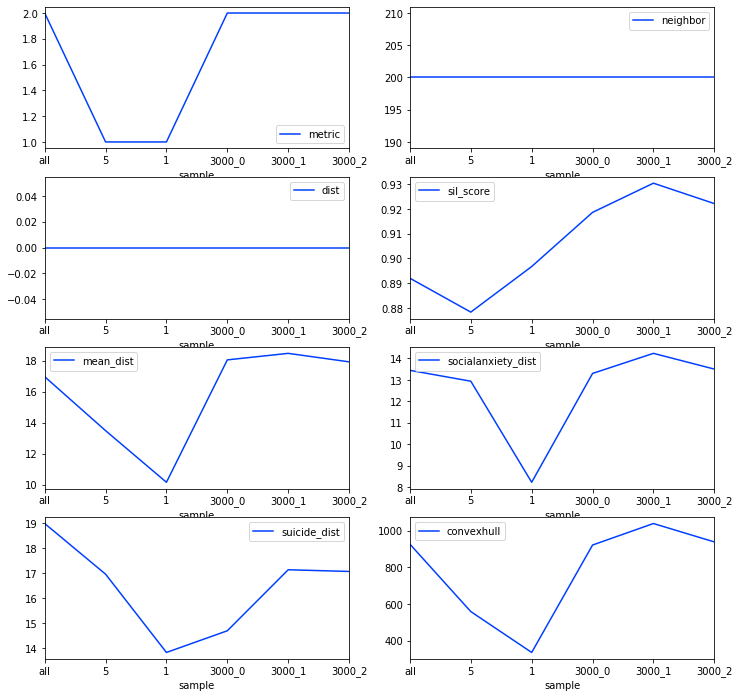

<Figure size 800x640 with 0 Axes>

In [151]:
# # fig=plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')

# fig, ax = plt.subplots(4,2, figsize=(12, 12))

# # idx = [[0,0],[0,1],[1,0],[1,1],[2,0],[2,1],[3,0],[3,1],]

# cols_len = len(cols[1:])
# plt.figure(figsize=(10, 8), dpi= 80, facecolor='w', edgecolor='k')
# for col,i in zip(cols[1:], range(cols_len)):
#     df.plot(x="sample", y=col, kind="line", ax=ax.flat[i])
# # plt.figure(figsize=(20,20))
# fig.savefig(output_dir+'umap_gs.png')
    

## See how stable UMAP is across runs and resampling

In [63]:
# data_folder = '/content/drive/My Drive/ML4HC_Final_Project/data/input/'
data_folder = './../../datum/reddit/input/'
input_dir = './../../datum/reddit/output/supervised_umap/umap_cluster_pre/'
# Create output_dir
timestamp = datetime.today().strftime('%Y-%m-%d-%H-%M')
output_dir = f'./../../datum/reddit/output/supervised_umap/umap_cluster_{pre_or_post}_{timestamp}/'
try: os.mkdir(output_dir)
except: pass


In [29]:
reddit_data = load_reddit(subreddits, data_folder=data_folder + 'final_features/', subsample = False,pre_or_post = 'pre')


(6935, 350)
===
addiction
(4092, 350)
===
adhd
(16659, 350)
===
alcoholism
(3084, 350)
===
anxiety
(19945, 350)
===
autism
(4563, 350)
===
bipolarreddit
(2715, 350)
===
bpd
(10987, 350)
===
depression
(21161, 350)
===
healthanxiety
(4246, 350)
===
lonely
(11519, 350)
===
schizophrenia
(4272, 350)
===
socialanxiety
(12261, 350)
===
suicidewatch
(19906, 350)


In [30]:
count = {}
for sr in subreddits:
    count_sr = reddit_data[reddit_data.subreddit==sr].shape[0]
    count[sr]=str(np.round(count_sr/1000,1))+'k'

count
    

{'EDAnonymous': '6.9k',
 'addiction': '4.1k',
 'adhd': '16.7k',
 'alcoholism': '3.1k',
 'anxiety': '19.9k',
 'autism': '4.6k',
 'bipolarreddit': '2.7k',
 'bpd': '11.0k',
 'depression': '21.2k',
 'healthanxiety': '4.2k',
 'lonely': '11.5k',
 'schizophrenia': '4.3k',
 'socialanxiety': '12.3k',
 'suicidewatch': '19.9k'}

In [24]:
# Visually inspect how much they're moving: create a gif

frame_dur = 1.5

filenames = os.listdir(input_dir)
filenames = [n for n in filenames if '.png' in n ][::5]


import imageio

images = list(map(lambda filename: imageio.imread(input_dir+filename), filenames))
imageio.mimsave(input_dir+'supervised_umap.gif', images, format='GIF', duration=frame_dur)

In [20]:
# Load distances for all 50 runs to compute var and rank mean distance for each sr

dists_all = []
ranked_index = []
files = os.listdir(input_dir)
files = [n for n in files if '_dists_hausdorff_' in n ]
for file in files:
    df = pd.read_csv(input_dir+file, index_col=0)
    df = df.sort_index()
    df = df.reindex(sorted(df.columns), axis=1)
    if len(np.unique(df.index)) < len(df.index):
        break
    dists_all.append(df.values)
    
    df_mean_ranked = df.mean()
    df_mean_ranked = df_mean_ranked.sort_values(0)
    df_mean_ranked_index = list(df_mean_ranked.index)
    ranked_index.append(df_mean_ranked_index)


In [32]:
# Append original sample size to subreddit name
subreddits_new = []
for sr in subreddits:
    name_new = sr+' '+count.get(sr)
    subreddits_new.append(name_new)

subreddits_new

['EDAnonymous 6.9k',
 'addiction 4.1k',
 'adhd 16.7k',
 'alcoholism 3.1k',
 'anxiety 19.9k',
 'autism 4.6k',
 'bipolarreddit 2.7k',
 'bpd 11.0k',
 'depression 21.2k',
 'healthanxiety 4.2k',
 'lonely 11.5k',
 'schizophrenia 4.3k',
 'socialanxiety 12.3k',
 'suicidewatch 19.9k']

In [33]:
# Compute variance across 50 runs
dists_all = np.array(dists_all)
dists_all_var = dists_all.std(axis=0)
dists_all_var = pd.DataFrame(dists_all_var)
dists_all_var.columns = subreddits
dists_all_var.index = subreddits
print('max:', dists_all_var.max().max())
dists_all_var



max: 11.21405339854582


,EDAnonymous,addiction,adhd,alcoholism,anxiety,autism,bipolarreddit,bpd,depression,healthanxiety,lonely,schizophrenia,socialanxiety,suicidewatch
EDAnonymous,0.000000,5.730265,5.351355,9.058024,5.194426,4.934638,5.043395,8.764540,5.863605,4.881013,7.319013,5.584078,5.755748,6.815542
addiction,7.199335,0.000000,6.793570,9.796107,5.680775,4.189514,4.106605,7.631756,4.716103,4.455397,7.639747,5.907771,4.441437,5.563617
adhd,6.895508,5.413689,0.000000,9.368559,6.831811,5.303761,3.909055,6.458874,4.672241,5.559160,6.081745,6.186143,7.667088,7.501538
alcoholism,7.903919,4.392433,10.898343,0.000000,9.173624,7.740076,3.791630,9.597775,9.347430,8.631254,8.409834,7.752492,9.611518,7.845808
anxiety,8.522765,6.129286,9.731074,8.241198,0.000000,5.522024,5.748818,7.560775,6.885787,8.834018,7.798480,7.485996,7.576733,9.838179
autism,9.661488,5.142679,9.005313,9.720901,6.443201,0.000000,5.770138,8.505932,7.473196,8.414578,7.573300,7.597072,9.352497,8.182059
bipolarreddit,5.054494,6.816983,4.432068,9.621375,6.387787,4.220379,0.000000,5.032908,4.955687,6.158970,6.184293,4.598862,3.933041,6.270145
bpd,7.952511,5.332056,8.948716,9.731894,5.910907,5.462174,3.556677,0.000000,5.172323,6.143513,6.842440,5.475649,7.792007,7.168441
depression,10.569129,6.518241,9.171070,11.214053,6.747449,7.612286,7.266961,8.328344,0.000000,8.752906,8.823123,8.979428,9.240852,9.027617
healthanxiety,6.221333,6.150915,7.662919,7.158765,6.160316,5.309359,3.565134,8.371710,5.709864,0.000000,7.792135,6.361049,7.440440,7.635362


### Create a heatmap with median and IQR 

In [40]:
# Median
df_median = np.median(dists_all, axis=0)
df_median = pd.DataFrame(df_median)
df_median.columns = subreddits_new
df_median.index = subreddits_new
print('max:', df_median.max().max())
df_median

max: 26.116760753026572


,EDAnonymous 6.9k,addiction 4.1k,adhd 16.7k,alcoholism 3.1k,anxiety 19.9k,autism 4.6k,bipolarreddit 2.7k,bpd 11.0k,depression 21.2k,healthanxiety 4.2k,lonely 11.5k,schizophrenia 4.3k,socialanxiety 12.3k,suicidewatch 19.9k
EDAnonymous 6.9k,0.000000,19.738357,16.096784,25.286881,21.200276,18.355749,19.592361,17.379674,19.673803,16.748818,19.992850,16.854797,16.699988,16.957179
addiction 4.1k,13.754849,0.000000,17.276271,15.712446,17.562456,13.045299,14.540948,16.368649,12.772887,12.866783,14.935955,15.684858,17.259460,16.385281
adhd 16.7k,14.590423,18.056043,0.000000,21.808773,19.626692,13.661558,19.606387,16.082403,18.945878,14.835830,18.148891,15.923343,12.743054,17.715390
alcoholism 3.1k,23.973728,17.292216,24.558717,0.000000,19.815803,12.772700,22.518135,11.573430,21.962783,23.689592,19.392912,25.495147,23.226254,26.116761
anxiety 19.9k,20.926857,16.906489,23.079020,17.672696,0.000000,12.301794,20.509640,18.493347,17.168769,18.312310,20.807143,20.767074,19.025831,21.185481
autism 4.6k,22.297888,16.856097,22.785303,18.885906,16.528446,0.000000,20.645568,15.851298,20.881109,21.954550,21.028220,22.418688,19.048711,22.628490
bipolarreddit 2.7k,7.830455,10.604614,12.877629,14.514981,11.775407,8.195835,0.000000,12.783886,8.718277,8.773078,10.688530,9.780701,11.192025,11.291634
bpd 11.0k,23.231178,19.184395,24.307222,22.401246,23.477695,17.898404,23.624310,0.000000,22.937868,23.216699,23.255703,24.945675,21.842070,24.009350
depression 21.2k,10.976122,15.329244,17.451239,18.124844,16.900546,11.390735,19.250257,11.107336,0.000000,15.626424,15.108275,15.941436,13.929183,15.822030
healthanxiety 4.2k,16.887890,17.998195,20.413419,24.231688,18.974261,16.889945,18.712353,19.311550,22.437074,0.000000,21.571758,18.387101,19.923773,20.712944


In [41]:
from scipy.stats import iqr
# IQR
df_iqr = iqr(dists_all, axis=0)
df_iqr = pd.DataFrame(df_iqr)
df_iqr.columns = subreddits_new
df_iqr.index = subreddits_new
print('max:', df_iqr.max().max())
df_iqr

max: 19.06764714630176


,EDAnonymous 6.9k,addiction 4.1k,adhd 16.7k,alcoholism 3.1k,anxiety 19.9k,autism 4.6k,bipolarreddit 2.7k,bpd 11.0k,depression 21.2k,healthanxiety 4.2k,lonely 11.5k,schizophrenia 4.3k,socialanxiety 12.3k,suicidewatch 19.9k
EDAnonymous 6.9k,0.000000,6.965390,7.030122,9.401016,5.985709,5.945916,7.914547,12.871758,9.149277,5.528225,9.726118,6.388704,4.738944,8.851637
addiction 4.1k,6.260952,0.000000,8.499926,10.640394,8.613813,5.637427,5.561694,9.883318,6.743391,3.910063,9.351524,7.907226,5.143319,8.169965
adhd 16.7k,8.441408,5.280287,0.000000,12.454582,13.727508,4.431040,5.826470,8.846689,7.722996,7.634561,9.285394,8.182704,7.491555,7.905976
alcoholism 3.1k,6.130015,2.855329,12.816430,0.000000,14.943627,13.663590,4.759813,10.846398,15.949088,10.618449,10.027584,8.513645,19.067647,8.958186
anxiety 19.9k,9.173638,7.038793,10.306282,8.890276,0.000000,5.050966,8.309000,8.051767,11.722026,15.028915,9.994030,12.211447,13.570850,13.196886
autism 4.6k,11.384508,4.785404,11.846847,12.065525,10.627318,0.000000,4.291982,9.781156,12.535971,13.981373,9.340443,14.068905,17.842303,11.089670
bipolarreddit 2.7k,5.130988,6.354700,6.272348,11.068054,8.688102,4.695232,0.000000,7.344150,5.111466,6.383451,9.463054,6.041661,5.257811,8.730727
bpd 11.0k,8.533053,4.635244,10.924367,12.006764,7.784754,8.902111,4.621608,0.000000,6.043952,7.825215,9.137373,7.428887,14.587981,8.918926
depression 21.2k,16.395490,8.304071,11.847822,16.454867,8.091706,13.181167,13.108374,9.492058,0.000000,15.607456,16.355252,14.099220,15.111671,15.819411
healthanxiety 4.2k,7.231142,6.262177,12.885358,10.625554,11.723781,6.839031,4.627806,12.687005,9.350856,0.000000,14.925239,6.449160,9.971329,11.116393


In [42]:
# Sort by sum of IQR 
sorted_iqr = list((df_iqr+df_iqr.T).sum().sort_values().index)

def reorder_index_cols(df, ordered_list):
    df = df.reindex(ordered_list)
    df = df[ordered_list]
    return df
    
df_median = reorder_index_cols(df_median, sorted_iqr)
df_iqr = reorder_index_cols(df_iqr, sorted_iqr)




<Figure size 9000x4500 with 0 Axes>

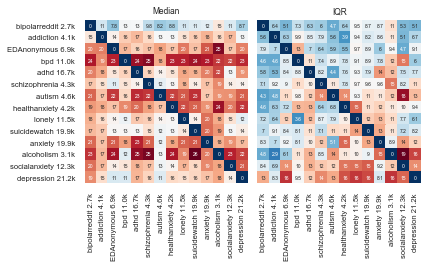

In [64]:
# Heatmap
sns.set(font_scale=0.7)
fontsize = 5
plt.figure(figsize=(30,15), dpi= 300, facecolor='w', edgecolor='k')
f, axes = plt.subplots(1, 2, sharey=True)

# plt.subplot(1, 2, 1)
ax = sns.heatmap(df_median, ax=axes[0],cmap = 'RdBu_r', annot=True,annot_kws={"fontsize":fontsize}, cbar=False)

axes[0].title.set_text('Median')
axes[0].set(adjustable='box', aspect='equal')

bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

# plt.subplot(1, 2, 2)
ax = sns.heatmap(df_iqr, ax=axes[1], cmap = 'RdBu_r', annot=True, annot_kws={"fontsize":fontsize},cbar=False)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
axes[1].title.set_text('IQR')
axes[1].set(adjustable='box', aspect='equal')
plt.tight_layout()
plt.savefig(output_dir+'heatmap_dists.png', dpi=300)



### Build X, y by grouping data by timestep (e.g., per week)

In [58]:
# if it's low, I'll have more timsteps to compute regression, if it's high I have more samples per timestep.
# Also: make sure not too many days are in the last timestep, which is removed. See windows below
subsample = 1300
reddit_data = load_reddit(subreddits, data_folder=data_folder, subsample = subsample,pre_or_post = 'post')
features = list(reddit_data.columns)
features = [n for n in features if n not in ['subreddit','author','date','post']]
timestep = 15
days = np.unique(reddit_data.date)

X = [] #shape (weeks, posts balanced by subreddits except COVID19_support, features)
y = []
for i in range(0,len(days),timestep)[:-1]: #remove last window cause it will have < timestep
  days_week = days[i:i+timestep]
  df_week = reddit_data[reddit_data.date.isin(days_week)]
  df_week_feature_cols = df_week[features].values
  df_week_y = list(df_week.subreddit)
  X.append(df_week_feature_cols)
  y.append(df_week_y)

X = np.array(X)
y = np.array(y)
days_week = days[::timestep]

(5034, 350)
(1300, 350)
===
addiction
(1781, 350)
(1300, 350)
===
adhd
(13571, 350)
(1300, 350)
===
alcoholism
(1424, 350)
(1300, 350)
===
anxiety
(15862, 350)
(1300, 350)
===
autism
(2204, 350)
(1300, 350)
===
bipolarreddit
(1365, 350)
(1300, 350)
===
bpd
(5962, 350)
(1300, 350)
===
depression
(37951, 350)
(1300, 350)
===
healthanxiety
(2419, 350)
(1300, 350)
===
lonely
(7937, 350)
(1300, 350)
===
schizophrenia
(1858, 350)
(1300, 350)
===
socialanxiety
(3728, 350)
(1300, 350)
===
suicidewatch
(21363, 350)
(1300, 350)


In [59]:
timesteps = X.shape[0]
print(f'samples: {X[2].shape}')
print(f'days: {len(days)}')
print(f'windows: {len(days)/timestep}')
print(f'timesteps: {timesteps}')
print(f'days per timestep: {timestep}')
print(f'samples per timestep: {1350/timesteps}')

samples: (2611, 346)
days: 111
windows: 7.4
timesteps: 7
days per timestep: 15
samples per timestep: 192.85714285714286


### Compute UMAP and measure distances for each timestep

In [65]:
plot = True

savefig_path = output_dir


0 out of 7
====metric: cosine,  200 neighbor (low=maintain local structure),  0 dist (low=tightly packed),  2D======
running umap...
running kmeans...
['EDAnonymous' 'addiction' 'adhd' 'alcoholism' 'anxiety' 'autism'
 'bipolarreddit' 'bpd' 'depression' 'healthanxiety' 'lonely'
 'schizophrenia' 'socialanxiety' 'suicidewatch']
plotting...
runnning metrics...

1 out of 7
====metric: cosine,  200 neighbor (low=maintain local structure),  0 dist (low=tightly packed),  2D======
running umap...
running kmeans...
['EDAnonymous' 'addiction' 'adhd' 'alcoholism' 'anxiety' 'autism'
 'bipolarreddit' 'bpd' 'depression' 'healthanxiety' 'lonely'
 'schizophrenia' 'socialanxiety' 'suicidewatch']
plotting...
runnning metrics...

2 out of 7
====metric: cosine,  200 neighbor (low=maintain local structure),  0 dist (low=tightly packed),  2D======
running umap...
running kmeans...
['EDAnonymous' 'addiction' 'adhd' 'alcoholism' 'anxiety' 'autism'
 'bipolarreddit' 'bpd' 'depression' 'healthanxiety' 'lonely'
 

<Figure size 432x288 with 0 Axes>

<Figure size 960x960 with 0 Axes>

<Figure size 438.97x360 with 0 Axes>

<Figure size 960x960 with 0 Axes>

<Figure size 438.97x360 with 0 Axes>

<Figure size 960x960 with 0 Axes>

<Figure size 438.97x360 with 0 Axes>

<Figure size 960x960 with 0 Axes>

<Figure size 438.97x360 with 0 Axes>

<Figure size 960x960 with 0 Axes>

<Figure size 438.97x360 with 0 Axes>

<Figure size 960x960 with 0 Axes>

<Figure size 438.97x360 with 0 Axes>

<Figure size 960x960 with 0 Axes>

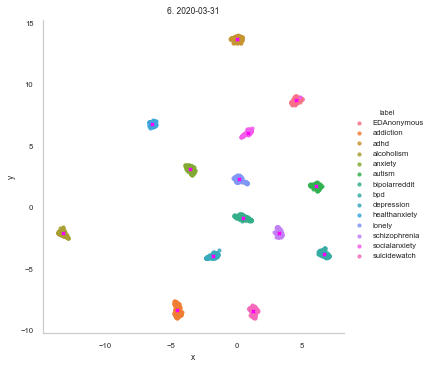

In [67]:
# Run
# If i want to run multiple times and average: 
    # for i, name in zip(sample_sizes, sample_names):
    # print('\n\n{} =========================================='.format(subsample))

name = subsample
results = {}
results_i = []
results_i_dists = [] #euclidean
results_i_dists_hausdorff = []
results_i_centers = []
features = list(reddit_data.columns)
features = [n for n in features if n not in ['subreddit','author','date','post']]
#   print('double check features: ',features)
# X = reddit_data[features].values
# y = reddit_data.subreddit.values

method = 'supervised'# 'metric_learning', 'supervised', 'unsupervised'
annotate = False
annotate_names = False
run_Ntimesteps = len(X)# len(X)#len(X) #1,2 ... len(X) 


for i, (X_i, y_i) in enumerate(zip(X[:run_Ntimesteps],y[:run_Ntimesteps])):
    print('\n{} out of {}'.format(i, run_Ntimesteps))
    start_day = days_week[i].replace('/', '-')
    start_day = f'{i}. {start_day}'
    color_code = y_i.copy()
    # Set up gridsearch
    n_dimensions =  [2,] #4,8,16,32,64,128] # https://umap-learn.readthedocs.io/en/latest/parameters.html
    n_neighbors = [200] #[50,100,200] # CANNOT USE MORE THAN N participants, default=10 Lower values seem to work better in 2D. This means that low values of n_neighbors will force UMAP to concentrate on very local structure
    min_dist = [0]  # default=0.1. Lower values seem to work better in 2D. controls how tightly UMAP is allowed to pack points together. Larger values of min_dist will prevent UMAP from packing point together and will focus instead on the preservation of the broad topological structure instead.
    metrics = ['cosine'] #,'cosine'] # cosine adds points?
    repeat_n = 1
    repeat = [1]*repeat_n # to check how much randomness is affecting results, one can repeat
    scalers = [StandardScaler()]

    gridsearch= gridsearch_sets(metrics, n_neighbors, min_dist, n_dimensions, scalers, repeat)
    for j, (metric,neighbor,dist,dimension,scaler, r) in enumerate(gridsearch):

        print('====metric: {},  {} neighbor (low=maintain local structure),  {} dist (low=tightly packed),  {}D======'.format(metric,neighbor,dist,dimension))
#         title = '{}_timestep_{}_metric_{}_neighbor_{}_dist'.format(i,metric,neighbor,dist)
        title = f'{start_day}'
        print('running umap...')         
        X_reduced, centers, centers_labels  = run_umap(X = X_i, y = y_i, method = method, scaler=  scaler, neighbor = neighbor , dist=dist, metric=metric, 
            color_code = color_code, annotate_names = annotate_names, annotate = annotate, title=title,
            savefig_path = savefig_path, plot = plot)

        print('runnning metrics...')
        # compute euclidean distances
        dists = euclidean_distances(centers)
        dists_df = pd.DataFrame(dists, columns = centers_labels, index=centers_labels)
        # hausdorff distance

        dists_df_hausdorff = hausdorff_distances(X_reduced,y_i, subreddits)
        # Compute silhouette score
        sil_score = silhouette_score(X_reduced, y_i)

        # centers
        df_centers = pd.DataFrame(centers)
        df_centers['labels'] = centers_labels     

        # Compute convex hull
        hull = ConvexHull(centers)
        hull_area = hull.volume #volume is area in 2D

        #     Append
        results_i.append([metric,neighbor,dist,sil_score, hull_area])
        results_i_dists.append(dists_df.values)
        results_i_dists_hausdorff.append(dists_df_hausdorff.values)
        results_i_centers.append(df_centers.values)

# general results


results_gs = pd.DataFrame(results_i)
results_gs.columns = ['metric', 'neighbor','dist', 'sil_score','convexhull']
results_gs = results_gs.sort_values('sil_score')
# np.save(results_gs, output_dir+f'run_{name}_umap_gs_params_scores.csv')
# results[name] = results_gs
# timestamp = datetime.now().isoformat()
results_gs.to_csv(output_dir+f'run_{name}_umap_gs_params_scores.csv')


# euclidean
np.save(output_dir+f'run_{name}_umap_gs_dists.npy',results_i_dists)
# results_gs_dists = pd.concat(results_i_dists)
# results_gs_dists.to_csv(output_dir+f'run_{name}_umap_gs_dists_{timestamp}.csv', )

# hausdorff
np.save(output_dir+f'run_{name}_umap_gs_dists_hausdorff.npy',results_i_dists_hausdorff)
# results_gs_dists_hausdorff = pd.concat(results_i_dists_hausdorff)
# results_gs_dists_hausdorff.to_csv(output_dir+f'run_{name}_umap_gs_dists_hausdorff_{timestamp}.csv' , ) 

# centers
# results_gs_centers = pd.concat(results_i_centers)
# results_gs_centers.to_csv(output_dir+f'run_{name}_umap_gs_centers_{timestamp}.csv', )
np.save(output_dir+f'run_{name}_umap_gs_centers.npy',results_i_dists_hausdorff)
print('done.')

### Visually inspect which subreddits are becoming closer with a line 
(this won't be useful because there are only 7 timesteps to fit the line, but it's good for inspection)

In [63]:
# Or fit a polynomial
def polyfit(x, y, degree):
    results = {}

    coeffs = numpy.polyfit(x, y, degree)

     # Polynomial Coefficients
    results['polynomial'] = coeffs.tolist()

    # r-squared
    p = numpy.poly1d(coeffs)
    # fit values, and mean
    yhat = p(x)                         # or [p(z) for z in x]
    ybar = numpy.sum(y)/len(y)          # or sum(y)/len(y)
    ssreg = numpy.sum((yhat-ybar)**2)   # or sum([ (yihat - ybar)**2 for yihat in yhat])
    sstot = numpy.sum((y - ybar)**2)    # or sum([ (yi - ybar)**2 for yi in y])
    results['determination'] = ssreg / sstot

    return results

In [68]:
import statsmodels.formula.api as smf
import numpy as np
import pandas as pd

x = np.array([0.0, 1.0, 2.0, 3.0,  4.0,  5.0])
y = np.array([0.0, 0.8, 0.9, 0.1, -0.8, -1.0])
degree = 3

df = pd.DataFrame(columns=['y', 'x'])
df['x'] = x
df['y'] = y

weights = np.polyfit(x, y, degree)
model = np.poly1d(weights)
results = smf.ols(formula='y ~ model(x)', data=df).fit()


In [69]:
import pandas as pd
import numpy as np
from sklearn import datasets, linear_model
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from scipy import stats

<Figure size 1200x1200 with 0 Axes>

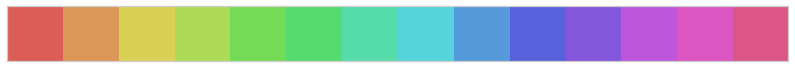

EDAnonymous


/Users/danielmlow/miniconda3/envs/edaic/lib/python3.6/site-packages/scipy/stats/stats.py:2315: RuntimeWarning: invalid value encountered in true_divide
  return (a - mns) / sstd


<Figure size 432x288 with 0 Axes>

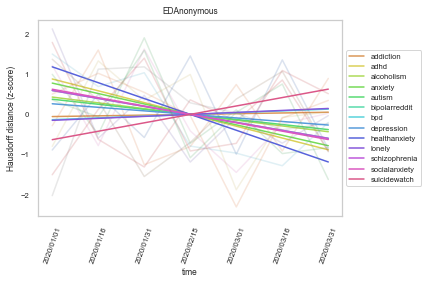

addiction


<Figure size 432x288 with 0 Axes>

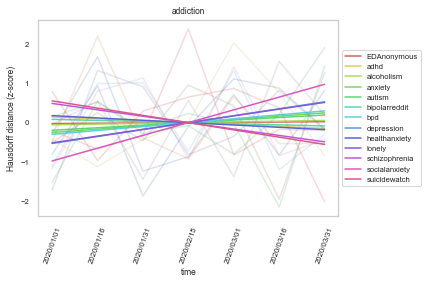

adhd


<Figure size 432x288 with 0 Axes>

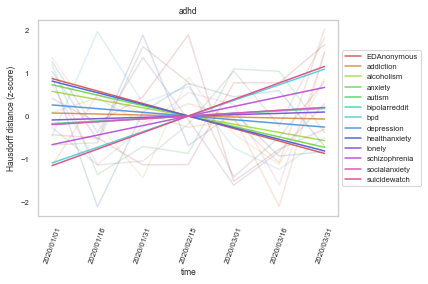

alcoholism


<Figure size 432x288 with 0 Axes>

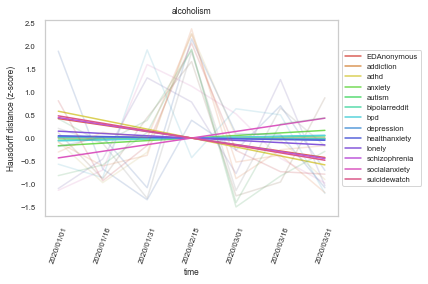

anxiety


<Figure size 432x288 with 0 Axes>

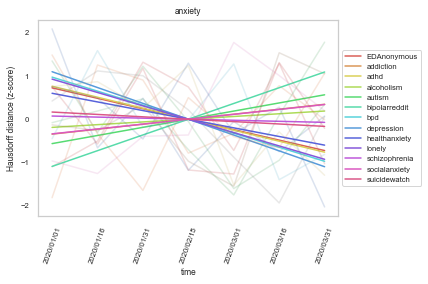

autism


<Figure size 432x288 with 0 Axes>

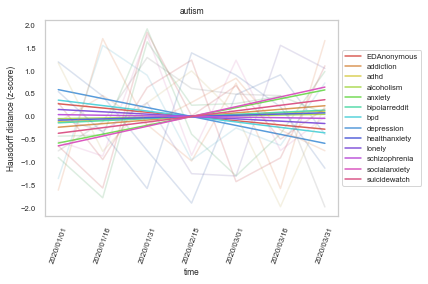

bipolarreddit


<Figure size 432x288 with 0 Axes>

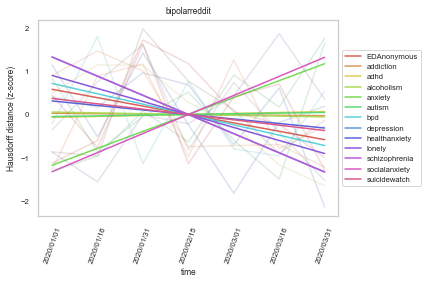

bpd


<Figure size 432x288 with 0 Axes>

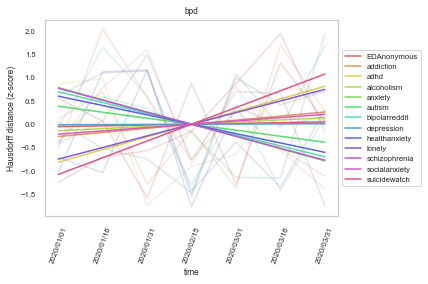

depression


<Figure size 432x288 with 0 Axes>

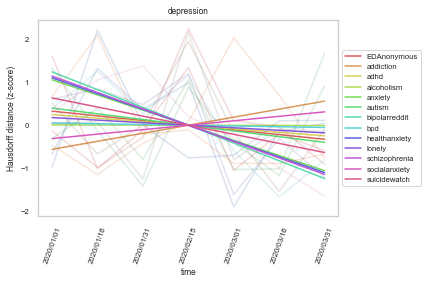

healthanxiety


<Figure size 432x288 with 0 Axes>

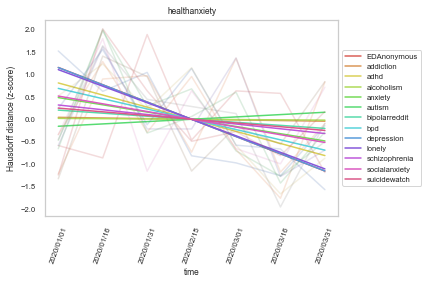

lonely


<Figure size 432x288 with 0 Axes>

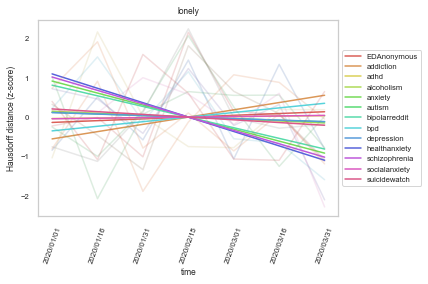

schizophrenia


<Figure size 432x288 with 0 Axes>

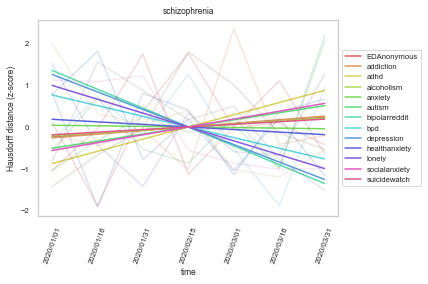

socialanxiety


<Figure size 432x288 with 0 Axes>

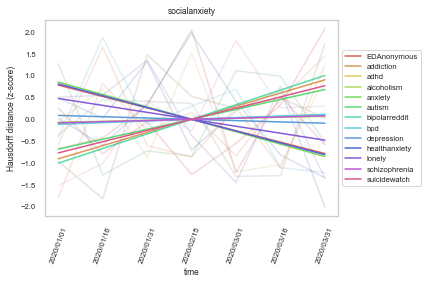

suicidewatch


<Figure size 432x288 with 0 Axes>

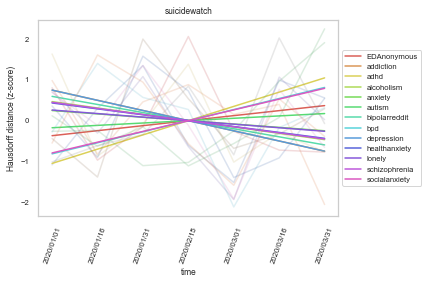

In [70]:
polynomial = False
savefig =True
try: os.mkdir(output_dir+'trends/')
except: pass


sns.set_style("whitegrid", {'axes.grid' : False})
plt.figure(figsize=(15,15), dpi= 80, facecolor='w', edgecolor='k')

results_i_dists_hausdorff = np.array(results_i_dists_hausdorff)
results_i_dists_hausdorff.shape

results_slope = {}
for sr_title in subreddits:
    results_slope[sr_title] = []
    
results_p_value = {}
for sr_title in subreddits:
    results_p_value[sr_title] = []
    
# todo: add text in plot

color = 'hls' #hls husl
palette = itertools.cycle(sns.color_palette(color, len(subreddits)))
sns.palplot(sns.color_palette(color, len(subreddits)))
plt.show()

for i, sr_title in enumerate(subreddits):
    print(sr_title)
    plt.clf()
    plt.figure()
    for j,sr_line in enumerate(subreddits):
        x = days_week[:-1] #last window is removed becuase < timestep
        x_digits = range(len(x))
        y = results_i_dists_hausdorff[:,j,i]
        y = zscore(y)
        if polynomial:
            if str(y[0]) =='nan':
                r_value, p_value = np.nan, np.nan
                continue
            df = pd.DataFrame(columns=['y', 'x'])
            df['x'] = x_digits
            df['y'] = y
            weights = np.polyfit(x_digits, y, polynomial) #polynomial=degree
            model = np.poly1d(weights)
            results = smf.ols(formula='y ~ model(x)', data=df).fit()
            p_value = results.pvalues[1]
            r2 = results.rsquared
            summary = results.summary()
        else:
            # linear             
            slope, intercept, r_value, p_value, std_err = stats.linregress(x_digits, y)            
            sns.lineplot(x, x_digits*slope + intercept, label = sr_line, color=next(palette))
            sns.lineplot(x, y,alpha=0.2)
            results_slope[sr_title].append(slope * r_value**2)
            results_p_value[sr_title].append(p_value)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.title( sr_title)
    plt.xlabel('time')
    plt.xticks(rotation=70)
    plt.ylabel('Hausdorff distance (z-score)')
    if savefig:
        plt.tight_layout()
        plt.savefig(output_dir+f'/trends/{sr_title}.png', dpi=300)
    plt.show()

##### We see healthanxiety, most are becoming similar towards the end.

### Here I tried to measure significance of slope but then realized there are only 7 timesteps, won't be significant after multiple comparison correction

In [643]:
# # Make DFs
# results_slope
# df_slope_r2 = pd.DataFrame(results_slope)
# df_slope_r2.index = subreddits
# df_slope_r2.columns = subreddits
# df_p_value = pd.DataFrame(results_p_value)
# df_p_value.index = subreddits
# df_p_value.columns = subreddits
# df_p_value


,addiction,EDAnonymous,adhd,autism,alcoholism,bipolarreddit,bpd,depression,anxiety,healthanxiety,lonely,schizophrenia,socialanxiety,suicidewatch
addiction,NaN,0.981761,0.597181,0.029213,0.730351,0.169104,0.943258,0.955885,0.494029,0.051113,0.010378,0.676500,0.306660,0.890582
EDAnonymous,0.990085,NaN,0.291599,0.218747,0.373905,0.717137,0.866177,0.892816,0.687618,0.012709,0.912783,0.351431,0.773263,0.548282
adhd,0.645332,0.289973,NaN,0.471689,0.413033,0.238900,0.155368,0.973893,0.218904,0.914805,0.988963,0.130316,0.945829,0.556581
autism,0.028966,0.201915,0.439221,NaN,0.298215,0.948622,0.987930,0.046014,0.217231,0.028122,0.423999,0.169907,0.301128,0.318618
alcoholism,0.731809,0.405829,0.428330,0.309392,NaN,0.922929,0.475950,0.938090,0.063358,0.213926,0.559648,0.682696,0.837933,0.234642
bipolarreddit,0.152083,0.725748,0.243579,0.998147,0.927708,NaN,0.797377,0.845200,0.102870,0.362754,0.335270,0.974076,0.737872,0.820976
bpd,0.865389,0.868895,0.155136,0.902409,0.448534,0.833650,NaN,0.984383,0.442487,0.012303,0.309674,0.697452,0.713029,0.971753
depression,0.930415,0.841163,0.992721,0.068279,0.862932,0.897604,0.973335,NaN,0.243502,0.156761,0.215679,0.168631,0.724507,0.637530
anxiety,0.515308,0.711587,0.211547,0.231729,0.048358,0.094760,0.446285,0.319616,NaN,0.944620,0.983354,0.650860,0.621787,0.701514
healthanxiety,0.048832,0.012489,0.978770,0.012298,0.204033,0.327026,0.010905,0.123373,0.986750,NaN,0.024561,0.352746,0.003889,0.326732


In [644]:
# # Extract tril
# def extract_tril(df):
#     df_tril = np.tril(df,k=0)
#     df_tril[df_tril == 0] = np.nan
#     df_tril = pd.DataFrame(df_tril, columns=df.columns, index=df.index)
#     return df_tril

# df_p_value_tril = extract_tril(df_p_value)
# df_slope_r2_tril = extract_tril(df_slope_r2)
# df_p_value_tril
    

,addiction,EDAnonymous,adhd,autism,alcoholism,bipolarreddit,bpd,depression,anxiety,healthanxiety,lonely,schizophrenia,socialanxiety,suicidewatch
addiction,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
EDAnonymous,0.990085,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
adhd,0.645332,0.289973,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
autism,0.028966,0.201915,0.439221,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
alcoholism,0.731809,0.405829,0.428330,0.309392,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
bipolarreddit,0.152083,0.725748,0.243579,0.998147,0.927708,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
bpd,0.865389,0.868895,0.155136,0.902409,0.448534,0.833650,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
depression,0.930415,0.841163,0.992721,0.068279,0.862932,0.897604,0.973335,NaN,NaN,NaN,NaN,NaN,NaN,NaN
anxiety,0.515308,0.711587,0.211547,0.231729,0.048358,0.094760,0.446285,0.319616,NaN,NaN,NaN,NaN,NaN,NaN
healthanxiety,0.048832,0.012489,0.978770,0.012298,0.204033,0.327026,0.010905,0.123373,0.986750,NaN,NaN,NaN,NaN,NaN


In [645]:
# import math
# pvals = df_p_value_tril.values.flatten()
# print(len(pvals))
# pvals = [n for n in pvals if n == n]
# print(len(pvals))

196
91


In [646]:
# reject, pvals_corrected, alpha_sidak, alpha_bonferroni = multipletests(pvals, alpha=0.05, method='fdr_bh', is_sorted=False, returnsorted=False)
# np.sum(reject)

0

In [647]:
# def multiple_comparisons(df_slope_r2, df_p_value):   
#     pvals = df_p_value_tril.values.flatten()
#     pvals = [n for n in pvals if n == n]
    
#     # Obtain mask of non-significant results
#     pvals= df_p_value.values.flatten() 
#     reject, pvals_corrected, alpha_sidak, alpha_bonferroni = multipletests(pvals, alpha=0.05, method='fdr_bh', is_sorted=False, returnsorted=False)

#     # Create mask with significant results
#     reject_opp = np.array([not c for c in reject]) #inverse mask of booleans
#     df_shape = df_p_value.shape # reshape to this shape
#     df_reject = pd.DataFrame(reject_opp.reshape(df_shape))
#     df_reject.columns = df_slope_r2.columns
#     df_reject.index = df_slope_r2.index
#     print('Significant results: ',np.sum(reject)/len(reject))
#     return df_slope, df_reject


<Figure size 432x288 with 0 Axes>

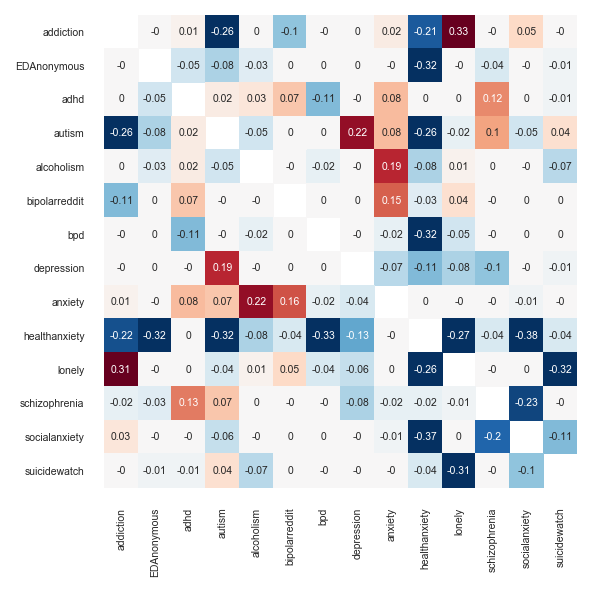

In [660]:

# # Plot
# plt.clf()
# fontsize = 5
# plt.figure(figsize=(4,4), dpi= 150, facecolor='w', edgecolor='k')
# ax = sns.heatmap(df_slope_r2.round(2), annot=True,cmap = 'RdBu_r',vmin=-0.25, vmax=.25, cbar=False,annot_kws={"fontsize":fontsize})
# plt.xticks(rotation=90, fontsize=fontsize)
# plt.yticks(rotation=0, fontsize=fontsize)
# bottom, top = ax.get_ylim()
# ax.set_ylim(bottom + 0.5, top - 0.5)
# plt.tight_layout()
# plt.savefig(output_dir+'/trends/heatmap.png',dpi=300)



### Compute percentiles with regards to 2019 pre data

In [104]:
distance_2020

17.34880807707237

In [106]:
# For each timestep, pairwise distance between clusters
results_i_dists_hausdorff.shape

(7, 14, 14)

In [165]:
# Choose a subreddit for the example
print(subreddits)

sr_example = 'EDAnonymous'
sr_example_index = subreddits.index(sr_example)
sr_example_index

['EDAnonymous', 'addiction', 'adhd', 'alcoholism', 'anxiety', 'autism', 'bipolarreddit', 'bpd', 'depression', 'healthanxiety', 'lonely', 'schizophrenia', 'socialanxiety', 'suicidewatch']


0

In [267]:
# Percentiles with regards to 2019
distance_3D_by_subreddit = []
percentile_3D_by_subreddit = []

# To plot an example:
distribution_2019_healthanxiety = []
distances_2020 = []

for sr_i in range(len(subreddits)):
    # sr_i = 4
    sr = subreddits[sr_i]     # eg health anxiety     
    check = sr
    # create df where I insert the distance 
    distance_df_sr = np.zeros(results_i_dists_hausdorff.shape[:2]).T # shape (timesteps,14)
    # create df where I insert what percentile the distance is with regards to 2019 data     
    percentile_df_sr = np.zeros(results_i_dists_hausdorff.shape[:2]).T # shape (timesteps,14)
    for timestep_i, timestep_df in enumerate(results_i_dists_hausdorff):
        # timestep_df has shape (14,14), pairwise dist for 1 timestep
        distances_sr = timestep_df[:,sr_i] #extract distances between this sr and other ones, the same as [sr_i, :] cause it's symmetrical
        for distance_i in range(len(distances_sr)):   
            distance_2020 = distances_sr[distance_i]             
            distance_df_sr [distance_i,timestep_i] = distance_2020
            #             
            distribution_2019 = dists_all[:,distance_i,sr_i]
            percentile = stats.percentileofscore(distribution_2019, distance_2020)
            percentile_df_sr [distance_i,timestep_i] = percentile        
            if  sr == 'healthanxiety' and distance_i == sr_example_index:
                # For example plot                 
                distances_2020.append(distance_2020)
                distribution_2019_healthanxiety.append(distribution_2019)
    percentile_3D_by_subreddit.append(percentile_df_sr)
    distance_3D_by_subreddit.append(distance_df_sr)


percentile_3D_by_subreddit = np.array(percentile_3D_by_subreddit)



In [268]:
timesteps = days_week[:-1]


In [269]:
distribution_2019_healthanxiety = distribution_2019_healthanxiety[0] #I append it 7 times, but they're all the same

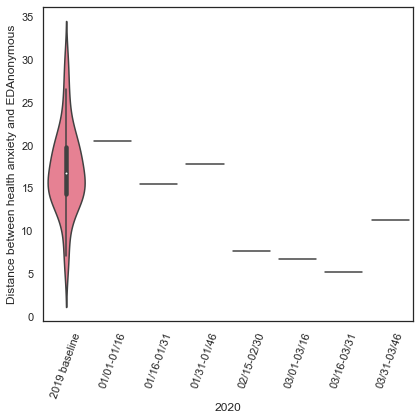

In [270]:
sns.set(style='white', rc={'figure.figsize':(6,6)}, font_scale =1, palette=sns.color_palette("husl", 15))

y = list(distribution_2019_healthanxiety) 

x = ['2019 baseline']*50   

for i in range(len(timesteps)):
    date = timesteps[i].replace('2020/', '')
    date_new = date+'-'+date[:3]+str(int(date[-2:])+15)
    x = x + [date_new]*50
    y = y + [distances_2020[i]]*50
    

sns.violinplot(x=x,y=y)
plt.xticks(rotation=70)
plt.xlabel('2020')
plt.ylabel(f'Distance between health anxiety and {sr_example}')
plt.tight_layout()
plt.savefig(output_dir+'example_distance_distribution.png', dpi=400)

### Plot distances

True

In [215]:
percentile_3D_by_subreddit.shape

(14, 14, 7)

In [256]:

percentile_non_outliers = (percentile_3D_by_subreddit < 95) & (percentile_3D_by_subreddit > 5)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15


<Figure size 600x600 with 0 Axes>

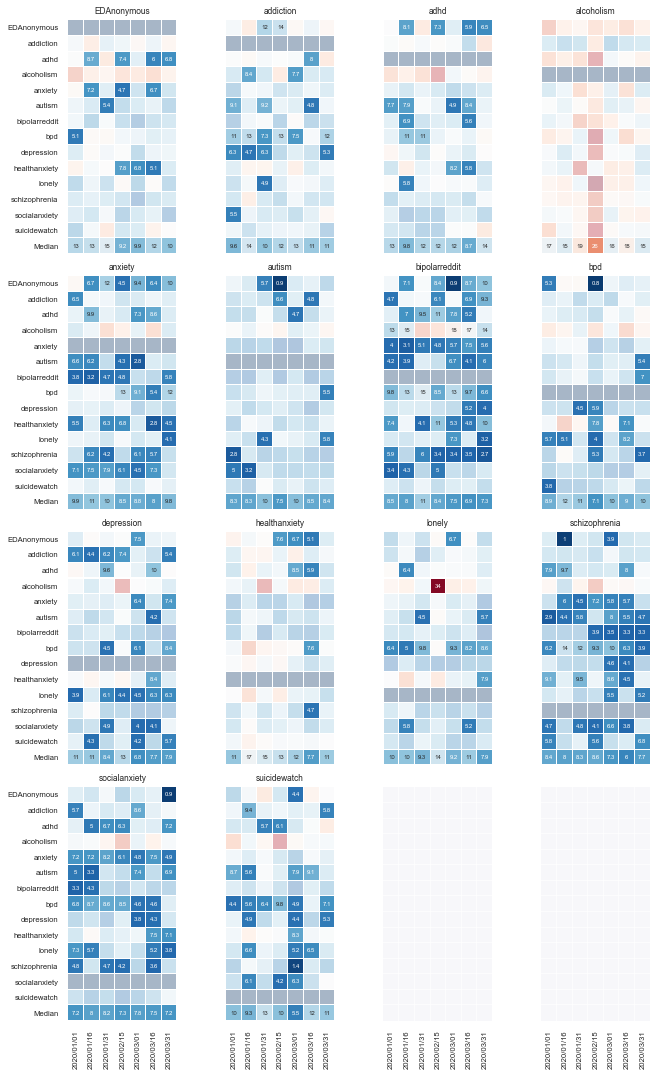

In [257]:

cmap = plt.get_cmap("RdBu_r")
cmap.set_bad(color='white', alpha=0.65)

# def plot_timestep_heatmaps(df, output_filename):
sns.set(font_scale=0.7)
fontsize = 6
dpi=100
savefig  =True
plt.figure(dpi= dpi, facecolor='w', edgecolor='k')
f, axes = plt.subplots(4, 4, sharex=True, sharey=True, figsize=(10,15),)
axes = [n for i in axes for n in i]

median_percentiles ={}

for i, ax in enumerate(axes):
    print(i)
    if i in [14,15]:
        df = np.ones((14,7))
        df = pd.DataFrame(df, columns=timesteps, index =subreddits)    
        df.loc['Median'] = np.ones(7)

        hm = sns.heatmap(df, annot=False, cbar=False,cmap = 'RdBu_r',mask = np.ones(df.shape), square=True, ax=ax, annot_kws={"fontsize":fontsize})
        bottom, top = hm.get_ylim()
        hm.set_ylim(bottom + 0.5, top - 0.5)
        ax.set(adjustable='box', aspect='equal')
    else:
        sr = subreddits[i]
        df = pd.DataFrame(distance_3D_by_subreddit[i], columns = timesteps, index=subreddits)
        df = pd.DataFrame(df, columns=timesteps, index =subreddits)    
        df.loc['Median'] = df.median()
        median_percentiles[sr] = np.array(df.median())

        # outliers         
        df_outliers = percentile_non_outliers[i]
        df_outliers = np.concatenate([df_outliers, [np.zeros(df.shape[1])]],axis=0)

        
        sns.heatmap(df.round(1), cbar=False,cmap = cmap, square=True, ax=ax, 
                         vmin=0, vmax=35,linewidths=0)
        hm = sns.heatmap(df.round(1), annot=True, cbar=False,cmap = cmap,mask =df_outliers, square=True, ax=ax, 
                         annot_kws={"fontsize":fontsize},vmin=0, vmax=35,linewidths=0.01)
        bottom, top = hm.get_ylim()
        hm.set_ylim(bottom + 0.5, top - 0.5)
        ax.title.set_text(sr)
        ax.set(adjustable='box', aspect='equal')



plt.tight_layout()
if savefig:
    plt.savefig(output_dir+f'/distances_all.png', dpi=400)
    


### Plot percentiles

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15


<Figure size 600x600 with 0 Axes>

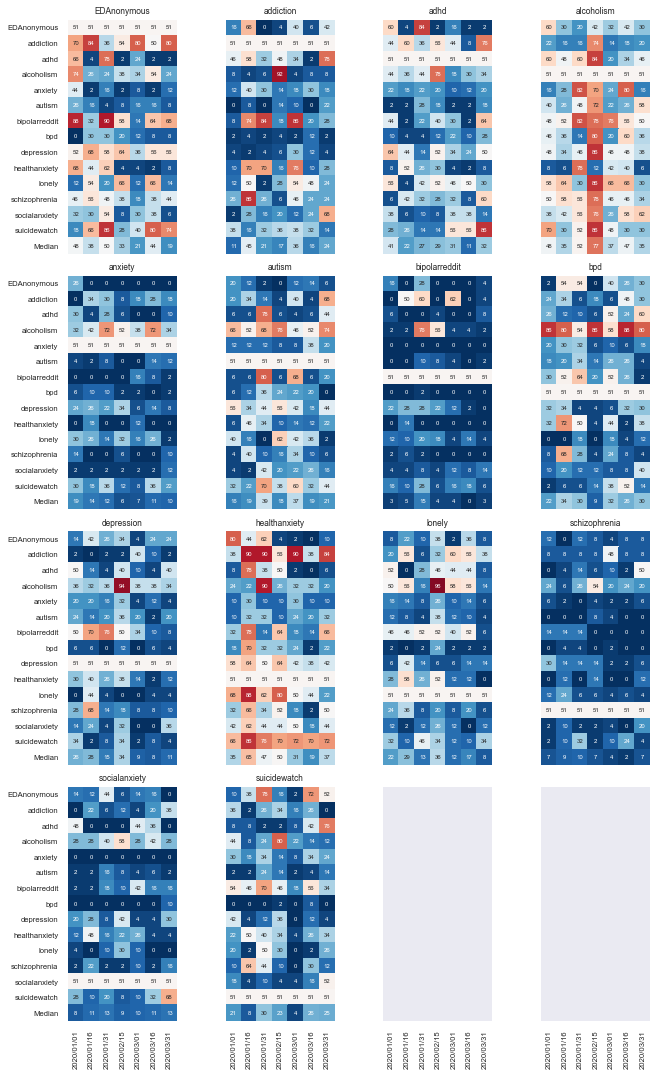

In [179]:

sns.set(font_scale=0.7)
fontsize = 6
dpi=100
savefig  =True
plt.figure(dpi= dpi, facecolor='w', edgecolor='k')
f, axes = plt.subplots(4, 4, sharex=True, sharey=True, figsize=(10,15))
axes = [n for i in axes for n in i]

median_percentiles ={}

for i, ax in enumerate(axes):
    print(i)
    if i in [14,15]:
        df = np.ones((14,7))
        df = pd.DataFrame(df, columns=timesteps, index =subreddits)    
        df.loc['Median'] = np.ones(7)

        hm = sns.heatmap(df, annot=False, cbar=False,cmap = 'RdBu_r', mask = np.ones(df.shape), square=True, ax=ax, annot_kws={"fontsize":fontsize})
        bottom, top = hm.get_ylim()
        hm.set_ylim(bottom + 0.5, top - 0.5)
        ax.set(adjustable='box', aspect='equal')
    else:
        sr = subreddits[i]
        df = pd.DataFrame(percentile_3D_by_subreddit[i], columns = timesteps, index=subreddits)
        df = pd.DataFrame(df, columns=timesteps, index =subreddits)    
        df.loc['Median'] = df.median()
        median_percentiles[sr] = np.array(df.median())

        hm = sns.heatmap(df.round(1), annot=True, cbar=False,cmap = 'RdBu_r', square=True, ax=ax, annot_kws={"fontsize":fontsize},
                        vmin=0, vmax=100)
        bottom, top = hm.get_ylim()
        hm.set_ylim(bottom + 0.5, top - 0.5)
        ax.title.set_text(sr)
        ax.set(adjustable='box', aspect='equal')


plt.tight_layout()
if savefig:
    plt.savefig(output_dir+f'/percentile_all.png', dpi=400)
    


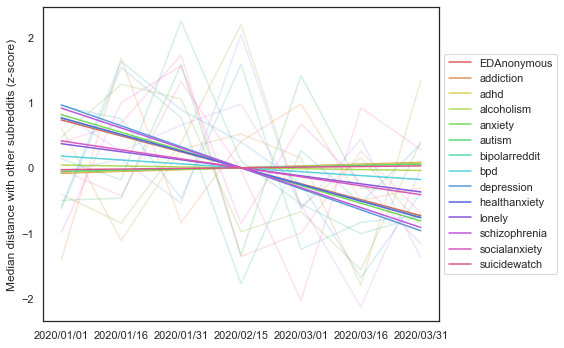

In [265]:
df = pd.DataFrame(median_percentiles)
df['timesteps'] = timesteps



# color = 'husl' #hls husl
# palette = itertools.cycle(sns.color_palette(color, len(subreddits)))
sns.set(style='white', rc={'figure.figsize':(8,5)}, font_scale =1, palette=sns.color_palette("husl", 14))
for sr in subreddits:
    x = np.array(df.timesteps)
    x_digits = np.array(range(len(x)))
    y = np.array(df[sr])
    y = zscore(y)
    slope, intercept, r_value, p_value, std_err = stats.linregress(x_digits, y)            
    sns.lineplot(x, x_digits*slope + intercept, label = sr, color=next(palette))
    sns.lineplot(x, y,alpha=0.2)
#     sns.lineplot(x = 'timesteps', y=sr, data = df, label=sr)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.ylabel('Median distance with other subreddits (z-score)')
plt.xticks(rotation=70)
plt.tight_layout()
plt.savefig(output_dir+'median_percentile_distance', dpi=300)

In [650]:
# # Percentiles with regards to 2019
# percentile_3D_by_timestep = []

# # for each timestep, obtain matrix of hausdorff distances      
# for timestep_df in results_i_dists_hausdorff:
#     # create empty matrix      
#     percentile_df = np.zeros(np.array(timestep_df).shape)
#     for row in range(timestep_df.shape[0]):
#         for col in range(timestep_df.shape[1]):
#             distance_2020 = np.array(timestep_df)[row,col]
#             distribution_2019 = dists_all[:,row,col]
#             percentile = stats.percentileofscore(distribution_2019, distance_2020)
#             percentile_df[row,col] = percentile
#     percentile_3D_by_timestep.append(percentile_df)    

# percentile_3D_by_timestep = np.array(percentile_3D_by_timestep)
    

<Figure size 432x288 with 0 Axes>

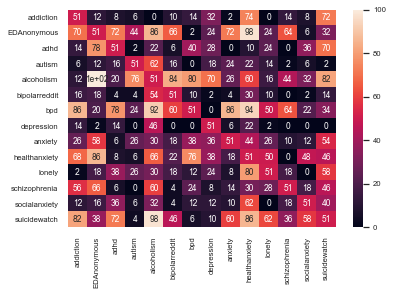

<Figure size 432x288 with 0 Axes>

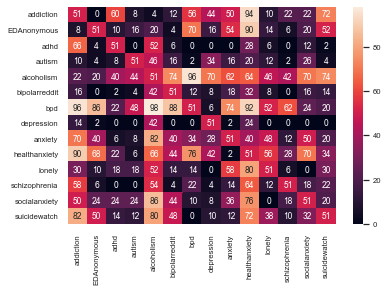

<Figure size 432x288 with 0 Axes>

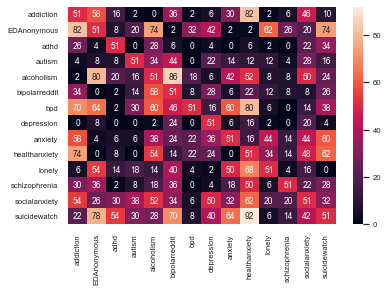

<Figure size 432x288 with 0 Axes>

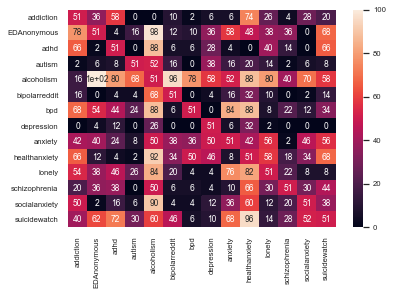

<Figure size 432x288 with 0 Axes>

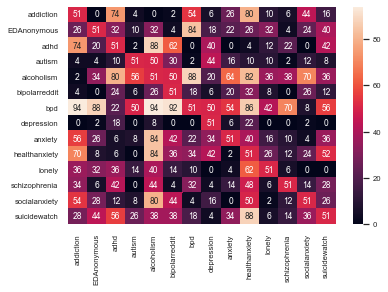

<Figure size 432x288 with 0 Axes>

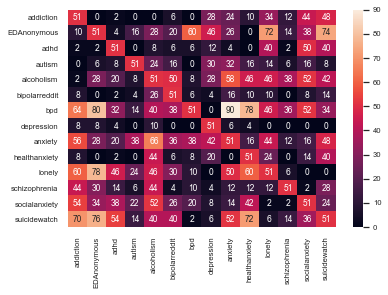

<Figure size 432x288 with 0 Axes>

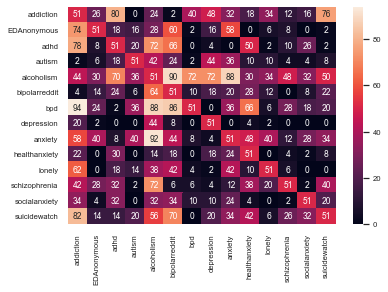

In [652]:
# for df in percentile_3D_by_timestep:
#     plt.clf()
#     plt.figure()
#     df = pd.DataFrame(df, columns=subreddits, index =subreddits)    
#     ax = sns.heatmap(df, annot=True, )
#     bottom, top = ax.get_ylim()
#     ax.set_ylim(bottom + 0.5, top - 0.5)
#     plt.show()

# Plot 2D for each timestep

plot=True

repeat_n = 50
sample_sizes = [3000] * repeat_n
sample_names = [f'3000_{n}' for n in range(repeat_n)]

if toy:
    repeat_n = 1
    sample_sizes = [50] * repeat_n
    sample_names = [f'50_{n}' for n in range(repeat_n)]

#     defined through argparse
i = sample_sizes[sample]
name = sample_names[sample]
savefig_path = output_dir+f'run_{name}_'

# for i, name in zip(sample_sizes, sample_names):
print('\n\n{} =========================================='.format(i))
results = {}
results_i = []
results_i_dists = [] #euclidean
results_i_dists_hausdorff = []
reddit_data = load_reddit(subreddits, data_folder=data_folder, subsample = i,pre_or_post = 'pre')
features = list(reddit_data.columns)
features = [n for n in features if n not in ['subreddit','author','date','post']]
#   print('double check features: ',features)
X = reddit_data[features].values
y = reddit_data.subreddit.values

method = 'supervised'# 'metric_learning', 'supervised', 'unsupervised'
annotate = False
annotate_names = False
run_Ntimesteps = 1# len(X)#len(X) #1,2 ... len(X) 
color_code = y.copy()


# Set up gridsearch
n_dimensions =  [2,] #4,8,16,32,64,128] # https://umap-learn.readthedocs.io/en/latest/parameters.html
n_neighbors = [200] #[50,100,200] # CANNOT USE MORE THAN N participants, default=10 Lower values seem to work better in 2D. This means that low values of n_neighbors will force UMAP to concentrate on very local structure
min_dist = [0]  # default=0.1. Lower values seem to work better in 2D. controls how tightly UMAP is allowed to pack points together. Larger values of min_dist will prevent UMAP from packing point together and will focus instead on the preservation of the broad topological structure instead.
metrics = ['cosine'] #,'cosine'] # cosine adds points?
repeat_n = 1
repeat = [1]*repeat_n # to check how much randomness is affecting results, one can repeat
scalers = [StandardScaler()]

gridsearch= gridsearch_sets(metrics, n_neighbors, min_dist, n_dimensions, scalers, repeat)
for j, (metric,neighbor,dist,dimension,scaler, r) in enumerate(gridsearch):
    print('\n{} out of {}'.format(j, len(gridsearch)))
    print('====metric: {},  {} neighbor (low=maintain local structure),  {} dist (low=tightly packed),  {}D======'.format(metric,neighbor,dist,dimension))
    title = '{}_metric_{}_neighbor_{}_dist'.format(metric,neighbor,dist)
    print('running umap...')         
    X_reduced, centers, centers_labels  = run_umap(X = X, y = y, method = method, scaler=  scaler, neighbor = neighbor , dist=dist, metric=metric, 
        color_code = color_code, annotate_names = annotate_names, annotate = annotate, title=title,
        savefig_path = savefig_path, plot = plot)

    print('runnning metrics...')
    # compute euclidean distances
    dists = euclidean_distances(centers)
    dists_df = pd.DataFrame(dists, columns = centers_labels, index=centers_labels)
    # hausdorff distance
    dists_df_hausdorff = hausdorff_distances(X_reduced,y, subreddits)
    # Compute silhouette score
    sil_score = silhouette_score(X_reduced, y)

    # Compute convex hull
    hull = ConvexHull(centers)
    hull_area = hull.volume #volume is area in 2D
    results_i.append([metric,neighbor,dist,sil_score, hull_area])
    results_i_dists.append(dists_df)
    results_i_dists_hausdorff.append(dists_df_hausdorff)

results_gs = pd.DataFrame(results_i)
results_gs.columns = ['metric', 'neighbor','dist', 'sil_score','convexhull']
results_gs = results_gs.sort_values('sil_score')
# results[name] = results_gs
timestamp = datetime.datetime.now().isoformat()
results_gs.to_csv(output_dir+f'run_{name}_umap_gs_params_scores_{timestamp}.csv')
# euclidean
results_gs_dists = pd.concat(results_i_dists)
results_gs_dists.to_csv(output_dir+f'run_{name}_umap_gs_dists_{timestamp}.csv', )
# hausdorff
results_gs_dists_hausdorff = pd.concat(results_i_dists_hausdorff)
results_gs_dists_hausdorff.to_csv(output_dir+f'run_{name}_umap_gs_dists_hausdorff_{timestamp}.csv', )
# 


# save_obj(results,output_dir+'supervised_clustering_{}timestep_v3'.format(timestep) )





results = load_obj(output_dir+'supervised_clustering_{}timestep_v3'.format(timestep))
results

# plot distance between all subreddits and anxiety for 

days = np.unique([key[0] for key in results.keys()])

results_anxiety = []



print(len(items_day))  





# Make sure there is the right amount. For instance, COVID19 appears in March so if there are 9 subreddits, then there should be 9 until March when there should be 10. 
unique_index =[]
day_sr = {}
for day in days:
    items_day = [item for item in results.items() if day in item[0]]
    sr = []
    for params in items_day:
      len_index = len(params[1].index)
      len_unique_index = len(np.unique(params[1].index))
      unique_index.append(len_unique_index)
      if len_unique_index<len_index: #change depending on subreddits - COVID19 which only appears later
        continue
      sr.append(params[1]['healthanxiety'])
    day_sr[day] = sr
    
  





sr_mean = []
sr_std = []

for day in days: 
  sr = day_sr.get(day)
  sr_df = pd.concat(sr, axis=1)
  sr_mean.append(sr_df.T.mean())
  sr_std.append(sr_df.T.std())



days

sr_mean_df = pd.concat(sr_mean, axis=1)
sr_mean_df.columns=days
sr_mean_df

sr_mean_df.T.plot.line(subplots=True, figsize = (14,20))

plt.style.use('seaborn-bright')
plt.figure(figsize=(14,20), dpi= 80, facecolor='w', edgecolor='k')
for sr2 in subreddits[1:]:
  sr1_sr2_df = pd.DataFrame(sr_mean_df.T[sr2].T)
  sr1_sr2_df['days'] = sr1_sr2_df.index
  sr1_sr2_df['range'] = range(len(sr1_sr2_df['days'].values))
  sns.lmplot(x='range',y=sr2,data=sr1_sr2_df,fit_reg=True, order=3) 


sr1_sr2_df

sr1_sr2_df = pd.DataFrame(sr_mean_df.T[sr2].T)
sr1_sr2_df

sr1_sr2_df['days'] = sr1_sr2_df.index

sr1_sr2_df

sr1_sr2_df
sr1_sr2_df = sr1_sr2_df.reset_index()
sr1_sr2_df.columns = ['days', 'dist_to_sr1']
sr1_sr2_df

items_day

# SKIP DFS WHERE THERE IS A REPEATED COLUMN/INDEX. 

# subreddits = ['mindfulness', 'healthanxiety', 'anxiety']

# Measure distances             
dists = euclidean_distances(centers)
dists_df = pd.DataFrame(dists, columns = centers_labels, index=centers_labels)
# Upper triangle
tri_dists = dists[np.triu_indices(len(centers_labels), 1)]
# Stats of upper triangle to measure overall convergence divergence
max_dist, avg_dist, min_dist = tri_dists.max(), tri_dists.mean(), tri_dists.min()
dists_df

centers

## How much do they agree?
 evaluating the adjusted Rand score and adjusted mutual information for this clustering as compared with the true labels.


from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score

(
    adjusted_rand_score(y_i, kmeans_labels),
    adjusted_mutual_info_score(y_i, kmeans_labels)
)

### ToDo: Can I plot distance on line?

# !pip install matplotlib-label-lines
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import loglaplace,chi2

from labellines import labelLine, labelLines

X = np.linspace(0,1,500)
A = [1,2,5,10,20]
funcs = [np.arctan,np.sin,loglaplace(4).pdf,chi2(5).pdf]

# plt.subplot(321)
for a in A:
    plt.plot(X,np.arctan(a*X),label=str(a))

labelLines(plt.gca().get_lines(),zorder=2.5)

# Plot 2D for each timestep
# https://stackoverflow.com/questions/52911890/labeling-distance-between-points-on-python-plot

# method = 'supervised'# 'metric_learning', 'supervised', 'unsupervised'
# savefig = False
# plot=True
# annotate = False
# annotate_names = False
# run_Ntimesteps = 1 #len(X) 

# # for each X_i, data in each timestep:
# for i, (X_i, y_i) in enumerate(zip(X[:run_Ntimesteps],y[:run_Ntimesteps])):
#     if method  == 'metric_learning' and i==0:
#         print('doing metric learning, train on first sample and test on rest')
#         color_code = y[0].copy()
#         continue

#     print(days_week[i])
#     if method == 'metric_learning':
#         color_code_test = y_i.copy()
#     else:
#         color_code = y_i.copy()
#     # groups = LabelEncoder().fit_transform(groups)
#     n_dimensions =  [2,]#4,8,16,32,64,128] # https://umap-learn.readthedocs.io/en/latest/parameters.html
#     n_neighbors = [48]#[8,16,24,32,40,48,56, 64]#15,20] # CANNOT USE MORE THAN N participants, default=10 Lower values seem to work better in 2D. This means that low values of n_neighbors will force UMAP to concentrate on very local structure
#     min_dist = [0.1]#[0.01, 0.1, 0.5, 1]#[0, 0.001,0.01, 0.1, 0.5]#0.25, 0.5, 0.75]  # default=0.1. Lower values seem to work better in 2D. controls how tightly UMAP is allowed to pack points together. Larger values of min_dist will prevent UMAP from packing point together and will focus instead on the preservation of the broad topological structure instead.
#     metrics = ['correlation'] # cosine adds points?
#     repeat_n = 1
#     repeat = [1]*repeat_n # to check how much randomness is affecting results, one can repeat
#     scalers = [StandardScaler()]

#     gridsearch= gridsearch_sets(metrics, n_neighbors, min_dist, n_dimensions, scalers, repeat)
#     for metric,neighbor,dist,dimension,scaler, r in gridsearch:
#         print('====metric: {},  {} neighbor (low=maintain local structure),  {} dist (low=tightly packed),  {}D======'.format(metric,neighbor,dist,dimension))
#         if method == 'metric_learning':
#             # need to add train and test (the last arguments)             
#             plot_lines(X)
#         else:    
#             X_reduced = plot_lines(X)



# distances = []
# x_0, y_0 = a[0], b[0]
# for i in range(len(a))[:-1]:
#     if i == len(a):
#             two_points = np.array([[a[i],b[i]],
#                   [a[0],b[0]],
#                  ])
#     else:
#         two_points = np.array([[a[i],b[i]],
#                       [a[i+1],b[i+1]],
#                      ])
#     print(two_points)
#     d = euclidean_distances(two_points)
#     print(d[0][1])
#     distances.append(d[0][1])
    

    
    # Plot distance on line, couldn't solve:     

    #     import itertools
    #     combs = list(itertools.combinations(centers,4))
    #     combs = [n for i in combs for n in i]
    #     combs = np.array(combs)
    #     combs
    #     dists = euclidean_distances(combs)
    
    #     for i in range(len(a)):
    #         if i == len(a):
    #             break
    #         plt.plot(a[i:i+1], b[i:i+1])
    #     plt.text(0.9, 0.2, 'cos')


## Output gif

In [ ]:
input_dir = '/Users/danielmlow/Dropbox (MIT)/libs/reddit/data/timestep_{}/'.format(timestep)
filenames = os.listdir(input_dir)
# images = []
# for filename in filenames:
#     images.append(imageio.imread(input_dir+filename))
# imageio.mimsave(input_dir+'supervised.gif', images)
import imageio
with imageio.get_writer(input_dir+'supervised.gif', mode='I') as writer:
    for filename in filenames:
        image = imageio.imread(input_dir+filename)
        writer.append_data(image)